<a href="https://colab.research.google.com/github/KeyMoney22/Plant_disease_classification-/blob/Inception-V3/Inception_V3_tomato_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importing Relevant Libraries

In [1]:
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import os
from PIL import Image
from tensorflow.keras import models, layers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Navigate to your folder
folder_path = '/content/drive/MyDrive/Tomato_dataset/PlantVillage'




## 2. Loading our dataset.

In [4]:
data= tf.keras.utils.image_dataset_from_directory(folder_path, labels='inferred', label_mode='categorical',
                                            class_names=None, color_mode='rgb', batch_size=32,
                                            image_size=(256, 256), shuffle=True, seed=None,
                                            validation_split=None, subset=None, interpolation='bilinear',
                                            follow_links=False, crop_to_aspect_ratio=False)

Found 18301 files belonging to 10 classes.


In [5]:
# Checking and printing the length of our data
print('The length of our data is', len(data))

# Checking the shape of our images and labels
for image_batch, label_batch in data:
  print('Image Batch Shape', image_batch.shape)
  print('Label Batch Shape', label_batch.shape)
  break
  #3 = rgb
  #32 = batch size
  # 256, 256= height , weight

The length of our data is 572
Image Batch Shape (32, 256, 256, 3)
Label Batch Shape (32, 10)


### Visualizing some of our images

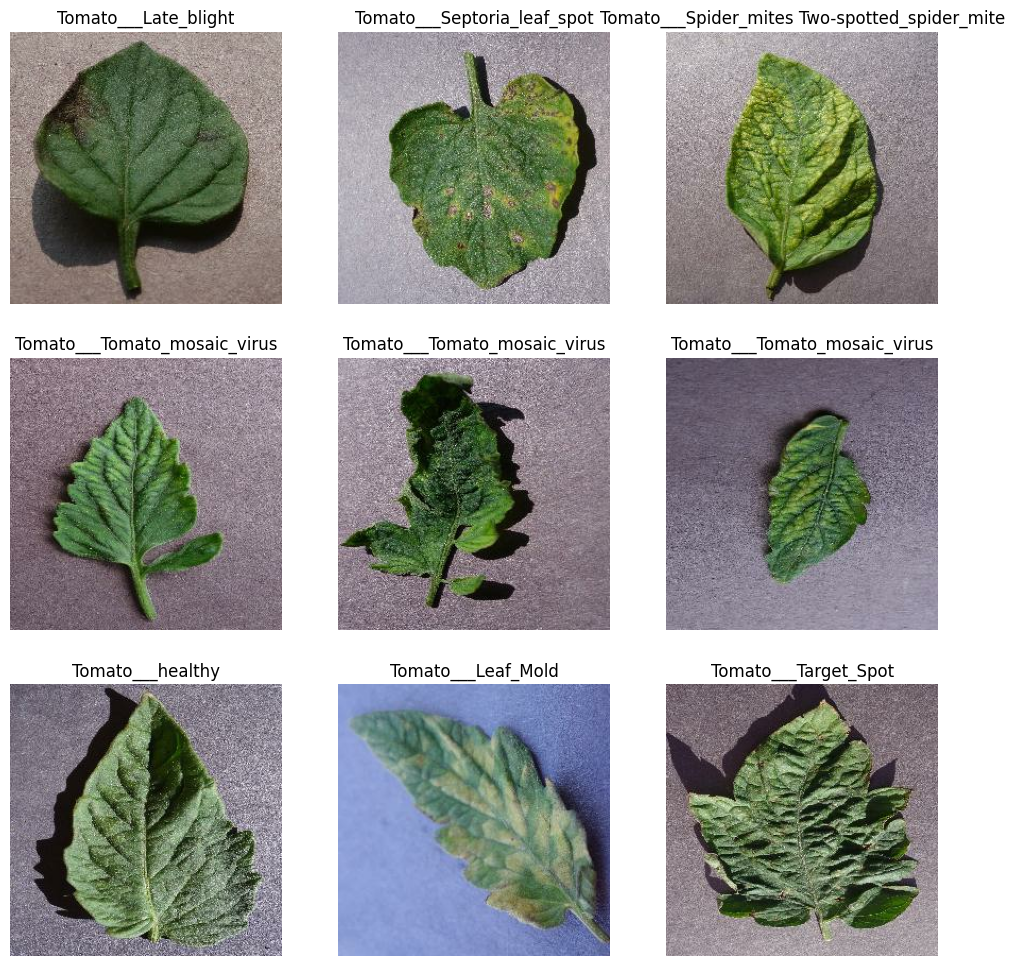

In [ ]:
def preview_data(dataset, class_names, num_images=9):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[tf.argmax(labels[i])])
            plt.axis("off")#hide the numbers
    plt.show()

class_names = data.class_names
preview_data(data, class_names)


## 3. Data Cleaning and Preperation

**Cleaning the class names**

In [ ]:
#Checking our class names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [ ]:
# Cleaning and printing the formarted class names
def clean_class_name(name):
    name = name.replace('__', '_')
    name = name.replace('__', '_')
    if name == 'Tomato_Spider_mites_Two_spotted_spider_mite':
        name = 'Tomato_Spider_mites'
    elif name == 'Tomato_Tomato_YellowLeaf_Curl_Virus':
        name = 'Tomato_Yellow_Leaf_Curl_Virus'
    elif name == 'Tomato_Tomato_mosaic_virus':
        name = 'Tomato_Mosaic_Virus'
    name = name.lower()
    return name

class_names = [clean_class_name(name) for name in class_names]
class_names

['tomato_bacterial_spot',
 'tomato_early_blight',
 'tomato_late_blight',
 'tomato_leaf_mold',
 'tomato_septoria_leaf_spot',
 'tomato_spider_mites two-spotted_spider_mite',
 'tomato_target_spot',
 'tomato_tomato_yellow_leaf_curl_virus',
 'tomato_mosaic_virus',
 'tomato_healthy']

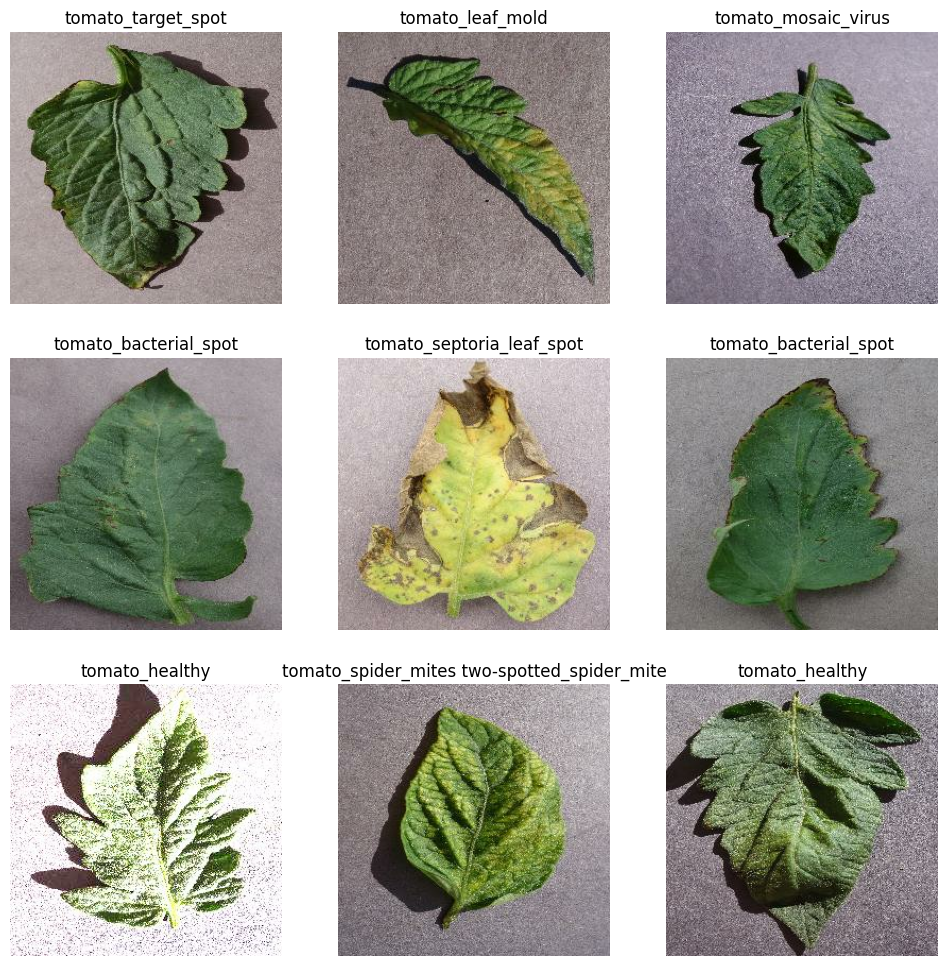

In [ ]:
preview_data(data, class_names)

**Checking for Corrupt images**

In [ ]:
#def check_corrupt_images(folder_path):
 #   corrupt_images = []
  #  for root, _, files in os.walk(folder_path):
   #     for file in files:
    #        try:
     #           img = Image.open(os.path.join(root, file))
      #          img.verify()  # Verify that it is, in fact, an image
       #     except (IOError, SyntaxError) as e:
        #        corrupt_images.append(os.path.join(root, file))
  #  return corrupt_images

#corrupt_images = check_corrupt_images(folder_path)
#print(f"Found {len(corrupt_images)} corrupt images.")

In [ ]:
# Removing Corrupt images
#for img_path in corrupt_images:
 #   try:
  #    os.remove(img_path)
   #   print(f"Corrupt image removed:{img_path}")
    #except OSError:
     # pass

**Class Distribution**

In [ ]:
# A function to check class distribution
#def check_class_distribution(dataset):
    #class_counts = {}
   # for images, labels in dataset:
  #      for label in labels:
        #    class_name = class_names[tf.argmax(label)]
       #     if class_name in class_counts:
      #          class_counts[class_name] += 1
     #       else:
    #            class_counts[class_name] = 1
   # return class_counts

# Checking class distribution
#class_distribution = check_class_distribution(data)

# Sorting the dictionary by values (class counts) in ascending order
#sorted_class_distribution = dict(sorted(class_distribution.items(), key=lambda item: item[1]))

#print("Sorted class distribution (ascending):", sorted_class_distribution)


In [ ]:
# Visualize class distribution with a horizontal bar chart
#plt.figure(figsize=(10, 8))
#plt.barh(list(sorted_class_distribution.keys()), list(sorted_class_distribution.values()), color='Teal')
#plt.title('Class Distribution')
#plt.xlabel('Frequency')
#plt.ylabel('Class')
#plt.show();

In our dataset, there is Class imbalance as observed in the graph above, leaf_curl_virus has the highest number of 3208 while tomato mosaic virus with the least observations of 373 as seen on the graph above.

**Splitting our data set**

In [6]:
# Creating a split of our data into train, validation and 80% ,10% and 10% Respectivly
def split_data(data, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size=10000):
  # Calculating the length of our dataset
  data_size = len(data)
  if shuffle:
    data = data.shuffle(shuffle_size) #Shuffling our data
  train_size = int(train_split* len(data))
  val_size = int(val_split*len(data))

  train_set = data.take(train_size)
  val_set = data.skip(train_size).take(val_size)
  test_set = data.skip(train_size).skip(val_size)

  return train_set, val_set, test_set


In [7]:
# Printing the length of our train, validation and test data
train_set, val_set, test_set = split_data(data)
print(len(train_set))
print(len(val_set))
print(len(test_set))

457
57
58


# Data Modeling

**Caching our data**

In [8]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Resizing, Rescaling and Augmentation**

In [9]:
img_size = 256

# Creating an instance to Resize our data
resize_and_rescale = tf.keras.Sequential([
                layers.Resizing(img_size,img_size),
                layers.Rescaling(1.0/255)
])

# Creating a data augmentation instance for our data
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)

])

In [10]:
# Apply data augmentation to the training set only
def augment(image, label):
    image = data_augmentation(image)
    return image, label

train_set = train_set.map(augment)

In [11]:
# Define the get_subset function if it's not defined elsewhere
def get_subset(dataset, fraction):
  """
  Returns a subset of the given dataset.

  Args:
    dataset: The dataset to extract a subset from.
    fraction: The fraction of the dataset to return.

  Returns:
    A subset of the original dataset.
  """
  subset_size = int(len(dataset) * fraction)
  return dataset.take(subset_size)

# Data Subset
train_subset = get_subset(train_set, 1/3)
val_subset = get_subset(val_set, 1/3)
test_subset = get_subset(test_set, 1/3)

**Base Model: CNN**

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the InceptionV3 model pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add a fully-connected layer
predictions = Dense(10, activation='softmax')(x)  # Add a softmax layer for classification

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
# Defining the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor ='val_accuracy',  # Monitor validation accuracy
    patience = 3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
# Train the model
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=10,
    callbacks = [early_stopping])

87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/10


In [ ]:
#CNN_InceptionV3
#Importing Libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from glob import glob

In [ ]:
# Define augmentation functions
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

# Apply augmentation to your dataset
train_subset = train_subset.map(augment_image)

# Batch and prefetch the dataset
train_subset = train_subset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
#import inceptionV3 model#
from tensorflow.keras.applications.inception_v3 import InceptionV3

image_size = 256
inception = InceptionV3(input_shape = (256,256,3), #shape of our images#
                        weights = 'imagenet', ##
                        include_top = False) #We are going to use all the layers in the model except for the last fully connected layeras#
                                                #as it is specific to the ImageNet competition.#

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [ ]:
#Flatten the output layer to 1 dimention#
x = Flatten()(inception.output)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load data
batch_size = 32
img_height = 256
img_width = 256

# Adjust the paths to your dataset directories
# Build the model
def build_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

input_shape = (img_height, img_width, 3)
model = build_model(input_shape)

# Print model summary
model.summary()

# Train the model
history = model.fit(train_set, epochs=10, validation_data=val_set)

# Evaluate the model on test data
eval_loss, eval_acc = model.evaluate(test_dataset)
print(f'Evaluation Loss: {eval_loss:.4f}')
print(f'Evaluation Accuracy: {eval_acc:.4f}')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_109 (Conv2D)         (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_110 (Conv2D)         (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_111 (Conv2D)         (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 30, 30, 128)      

InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-33-4fb08014d195>", line 40, in <cell line: 40>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy

logits and labels must have the same first dimension, got logits shape [32,10] and labels shape [320]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_14332]